In [1]:
"""
Lagrangian DA for the 2-layer QG system
"""

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from Lagrangian_tracer import Lagrange_tracer_model
from conjugate_symm_tool import verify_conjugate_symmetry, find_non_conjugate_pairs
from Lagrangian_DA import Lagrangian_DA_OU, truncate, get_A_OU, forward_, mu2psi, inv_truncate
from ene_spectrum import eigen2layer, adjust_ik, trunc2full
import h5py
from scipy import sparse
from time import time

# fix the random seed
np.random.seed(2024)


In [3]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu4e-7_beta60_K16_dt1e-5_tr.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    jacob_k_t = np.transpose(file['jacob_t'][()], axes=(3, 2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    rhs_q_k_t = np.transpose(file['rhs_q_t'][()], axes=(3, 2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    rhs_q21_k_t = np.transpose(file['rhs_q21_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    rhs_q22_k_t = np.transpose(file['rhs_q22_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    rhs_q23_k_t = np.transpose(file['rhs_q23_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
#     s_rate = file['s_rate'][()][0,0]
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
jacob_k_t = jacob_k_t['real'] + 1j * jacob_k_t['imag']
rhs_q_k_t = rhs_q_k_t['real'] + 1j * rhs_q_k_t['imag']
rhs_q21_k_t = rhs_q21_k_t['real'] + 1j * rhs_q21_k_t['imag']
rhs_q22_k_t = rhs_q22_k_t['real'] + 1j * rhs_q22_k_t['imag']
rhs_q23_k_t = rhs_q23_k_t['real'] + 1j * rhs_q23_k_t['imag']
h_hat = np.fft.fft2(topo)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'jacob_t', 'ke', 'params', 'psi_1_t', 'psi_2_t', 'qp', 'rhs_q21_t', 'rhs_q22_t', 'rhs_q23_t', 'rhs_q_t', 's_rate', 'tol', 'topo', 'u1_t', 'utz', 'v1_t', 'vb']>
psi1_k_t.shape (16, 16, 10000)


## DA

In [31]:
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # enforce conjugate symmetry
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0
#     psi1_hat[:, K//2, :] = 0
#     psi2_hat[:, K//2, :] = 0

    # Precompute constants
    K_squared_kd2 = K_squared + kd**2 / 2
    K_squared2 = K_squared**2
    K_squared4 = K_squared**4
    invCk = K_squared * (K_squared + kd**2)
    dX = 1j * KX
    dX[:, K//2] = 0 # enforce conjugate symmetry

    # linear part for A0, a0, A1 and a1
    linear_A0 = dX * ((K_squared_kd2 * beta - K_squared2 * U) * psi1_hat - kd**2/2 * U * h_hat) - nu * K_squared4 * (invCk * psi1_hat - kd**2/2 * h_hat)
    linear_a0 = dX * ((kd**2/2 * beta - kd**2 * K_squared * U) * psi1_hat - K_squared_kd2 * U * h_hat) + nu * K_squared4 * K_squared_kd2 * h_hat
    linear_A1_diag = dX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = dX * (K_squared_kd2 * beta + K_squared2 * U) - K_squared_kd2 * kappa * K_squared - nu * K_squared4 * invCk
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    for ik_, (k, ik) in enumerate(k_index_map.items()):
        kx, ky = k
        ikx, iky = ik
        k_sq = kx**2 + ky**2
        for im_, (m, im) in enumerate(k_index_map.items()):
            mx, my = m
            imx, imy = im
            m_sq = mx**2 + my**2
            psi1_m = psi1_hat[:, imy, imx]
            n = (kx-mx, ky-my)
            if n in k_index_map:
                inx, iny = k_index_map[n]
                psi1_n = psi1_hat[:, iny, inx]
                h_n = h_hat[iny, inx]
                det_mn = np.linalg.det(np.array([m, n]))
                nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_sq + kd**2/2) * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2/2 * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_A1[:, ik_, im_] += det_mn * kd**2/2 * (k_sq * psi1_n - h_n)
                nonlinear_sum_a1[:, ik_, im_] -= det_mn * (k_sq * kd**2/2 * psi1_n + (k_sq + kd**2/2) * h_n) 
        
    nonlinear_sum_A0 = nonlinear_sum_A0 / K**2
    nonlinear_sum_a0 = nonlinear_sum_a0 / K**2
    nonlinear_sum_A1 = nonlinear_sum_A1 / K**2
    nonlinear_sum_a1 = nonlinear_sum_a1 / K**2
    
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    nonlinear_sum_A1[:, K//2::K, :] = 0
    nonlinear_sum_A1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_a1[:, K//2::K, :] = 0
    nonlinear_sum_a1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_A0[:, :, K//2] = 0
    nonlinear_sum_a0[:, :, K//2] = 0
    nonlinear_sum_A0[:, K//2, :] = 0
    nonlinear_sum_a0[:, K//2, :] = 0
    A1[:, K//2::K, :] = 0
    A1[:, K//2*K:(K//2+1)*K, :] = 0
    a1[:, K//2::K, :] = 0
    a1[:, K//2*K:(K//2+1)*K, :] = 0
    
    # normalization 
    Ck = 1 / invCk
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1


In [32]:
# DA
N = 10000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# initialized
sigma_1 = 2.
sigma_2 = 4. * np.ones(K**2)
InvBoB = 1 / sigma_1**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
N_chunk = 2000 

for i in range(1, N):
    i_chunk = (i-1) % N_chunk
    if i_chunk == 0:
        A0_t, a0_t, A1_t, a1_t= get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_k_t[:,:,i-1:i-1+N_chunk], psi2_k_t[:,:,i-1:i-1+N_chunk], h_hat)
    
    A0 = A0_t[i_chunk, :]
    a0 = a0_t[i_chunk, :]
    A1 = A1_t[i_chunk, :, :]
    a1 = a1_t[i_chunk, :, :]

    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_16397/4245595930.py:87: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [33]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 10000)

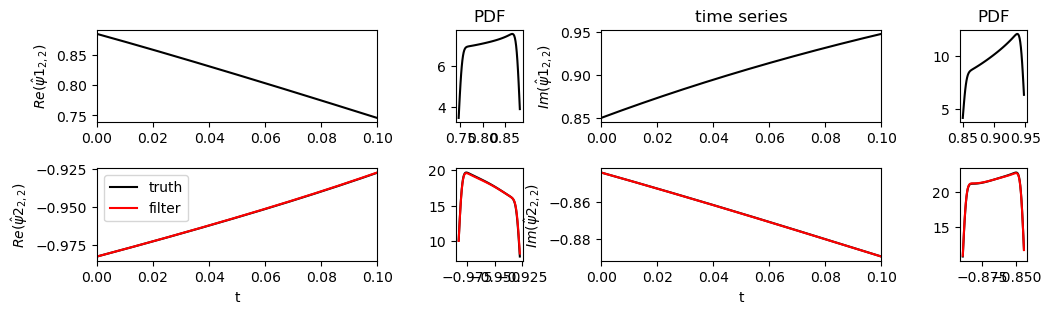

In [34]:
# Plot the time series
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

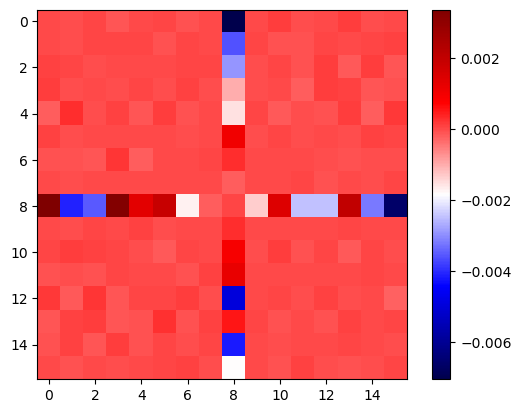

In [35]:
# Plot the last time unit error
plt.imshow((mu_t[:,:,-1] - psi2_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

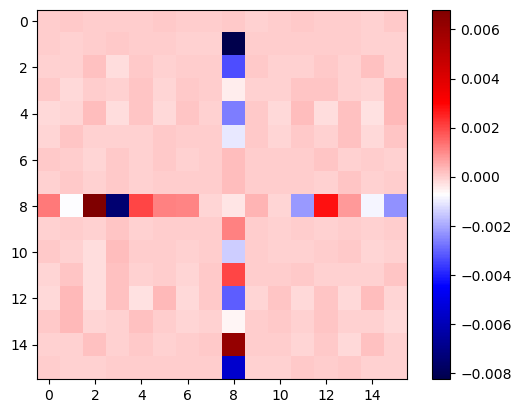

In [36]:
# Plot the last time unit error
plt.imshow((mu_t[:,:,-1] - psi2_k_t[:,:,-1]).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

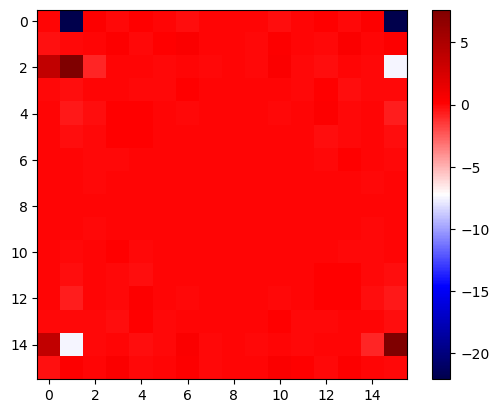

In [38]:
# Plot the last time unit error
plt.imshow((psi2_k_t[:,:,-1]).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

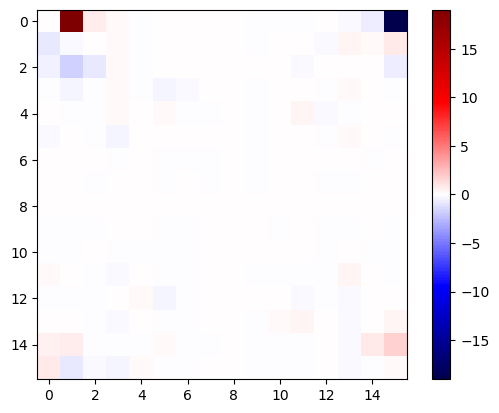

In [37]:
# Plot the last time unit error
plt.imshow((psi2_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

In [17]:
# check model prediction - Euler, prior is truth
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # enforce conjugate symmetry
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0
#     psi1_hat[:, K//2, :] = 0
#     psi2_hat[:, K//2, :] = 0

    # Precompute constants
    K_squared_kd2 = K_squared + kd**2 / 2
    K_squared2 = K_squared**2
    K_squared4 = K_squared**4
    invCk = K_squared * (K_squared + kd**2)
    dX = 1j * KX
    dX[:, K//2] = 0 # enforce conjugate symmetry

    # linear part for A0, a0, A1 and a1
    linear_A0_1 = dX * ((K_squared_kd2 * beta - K_squared2 * U) * psi1_hat)
    linear_a0_1 = dX * ((kd**2/2 * beta - kd**2 * K_squared * U) * psi1_hat)  
    linear_A1_1_diag = dX * (kd**2/2 * beta + kd**2 * K_squared * U)
    linear_a1_1_diag = dX * (K_squared_kd2 * beta + K_squared2 * U)
    linear_A1_1 = np.tile(np.diag(linear_A1_1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1_1 = np.tile(np.diag(linear_a1_1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1))
    
    linear_A0_3 = dX * (- kd**2/2 * U * h_hat)
    linear_a0_3 = dX * (- K_squared_kd2 * U * h_hat)  
    
    linear_A0 = dX * ((K_squared_kd2 * beta - K_squared2 * U) * psi1_hat - kd**2/2 * U * h_hat) - nu * K_squared4 * (invCk * psi1_hat - kd**2/2 * h_hat)
    linear_a0 = dX * ((kd**2/2 * beta - kd**2 * K_squared * U) * psi1_hat - K_squared_kd2 * U * h_hat) + nu * K_squared4 * K_squared_kd2 * h_hat
    linear_A1_diag = dX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = dX * (K_squared_kd2 * beta + K_squared2 * U) - K_squared_kd2 * kappa * K_squared - nu * K_squared4 * invCk
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    for ik_, (k, ik) in enumerate(k_index_map.items()):
        kx, ky = k
        ikx, iky = ik
        k_sq = kx**2 + ky**2
        for im_, (m, im) in enumerate(k_index_map.items()):
            mx, my = m
            imx, imy = im
            m_sq = mx**2 + my**2
            psi1_m = psi1_hat[:, imy, imx]
            n = (kx-mx, ky-my)
            if n in k_index_map:
                inx, iny = k_index_map[n]
                psi1_n = psi1_hat[:, iny, inx]
                h_n = h_hat[iny, inx]
                det_mn = np.linalg.det(np.array([m, n]))
                nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_sq + kd**2/2) * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2/2 * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_A1[:, ik_, im_] += det_mn * kd**2/2 * (k_sq * psi1_n - h_n)
                nonlinear_sum_a1[:, ik_, im_] -= det_mn * (k_sq * kd**2/2 * psi1_n + (k_sq + kd**2/2) * h_n) 
        
    nonlinear_sum_A0 = nonlinear_sum_A0 / K**2
    nonlinear_sum_a0 = nonlinear_sum_a0 / K**2
    nonlinear_sum_A1 = nonlinear_sum_A1 / K**2
    nonlinear_sum_a1 = nonlinear_sum_a1 / K**2
    
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    
    # enforce conjugate symmetry
    nonlinear_sum_A1[:, K//2::K, :] = 0
    nonlinear_sum_A1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_a1[:, K//2::K, :] = 0
    nonlinear_sum_a1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_A0[:, :, K//2] = 0
    nonlinear_sum_a0[:, :, K//2] = 0
    nonlinear_sum_A0[:, K//2, :] = 0
    nonlinear_sum_a0[:, K//2, :] = 0
    A1[:, K//2::K, :] = 0
    A1[:, K//2*K:(K//2+1)*K, :] = 0
    a1[:, K//2::K, :] = 0
    a1[:, K//2*K:(K//2+1)*K, :] = 0
    
    # normalization 
    Ck = 1 / invCk
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1, nonlinear_sum_A0*Ck, nonlinear_sum_a0*Ck, nonlinear_sum_A1*Ck_, nonlinear_sum_a1*Ck_, linear_A0_1*Ck, linear_a0_1*Ck, linear_A1_1*Ck_, linear_a1_1*Ck_, linear_A0_3*Ck, linear_a0_3*Ck

N = 10000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# initialized
psi1_k_pred = np.zeros((K*K, N), dtype=complex)
psi2_k_pred = np.zeros((K*K, N), dtype=complex)
jacob1_k_pred = np.zeros((K*K, N), dtype=complex)
jacob2_k_pred = np.zeros((K*K, N), dtype=complex)
linear1_k_pred = np.zeros((K*K, N), dtype=complex)
linear2_k_pred = np.zeros((K*K, N), dtype=complex)
# linear1_1_k_pred = np.zeros((K*K, N), dtype=complex)
# linear2_1_k_pred = np.zeros((K*K, N), dtype=complex)
# linear1_3_k_pred = np.zeros((K*K, N), dtype=complex)
# linear2_3_k_pred = np.zeros((K*K, N), dtype=complex)
psi1_k_pred[:, 0] = psi1_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
psi2_k_pred[:, 0] = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
N_chunk = 1000 

for i in range(1, N):
    i_chunk = (i-1) % N_chunk
    if i_chunk == 0:
        A0_t, a0_t, A1_t, a1_t, nonlinear_A0_t, nonlinear_a0_t, nonlinear_A1_t, nonlinear_a1_t,linear_A0_1_t, linear_a0_1_t, linear_A1_1_t, linear_a1_1_t, linear_A0_3_t, linear_a0_3_t = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_k_t[:,:,i-1:i-1+N_chunk], psi2_k_t[:,:,i-1:i-1+N_chunk], h_hat)
    
    A0 = A0_t[i_chunk, :]
    a0 = a0_t[i_chunk, :]
    A1 = A1_t[i_chunk, :, :]
    a1 = a1_t[i_chunk, :, :]

    nonlinear_A0 = nonlinear_A0_t[i_chunk, :, :]
    nonlinear_a0 = nonlinear_a0_t[i_chunk, :, :]
    nonlinear_A1 = nonlinear_A1_t[i_chunk, :, :]
    nonlinear_a1 = nonlinear_a1_t[i_chunk, :, :]
    
#     linear_A0_1 = linear_A0_1_t[i_chunk, :, :]
#     linear_a0_1 = linear_a0_1_t[i_chunk, :, :]
#     linear_A1_1 = linear_A1_1_t[i_chunk, :, :]
#     linear_a1_1 = linear_a1_1_t[i_chunk, :, :]
#     linear_A0_3 = linear_A0_3_t[:, :]
#     linear_a0_3 = linear_a0_3_t[:, :]
    
#     linear1_1_k_pred[:, i] = (linear_A0_1.flatten(order='F') + linear_A1_1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt
#     linear2_1_k_pred[:, i] = (linear_a0_1.flatten(order='F') + linear_a1_1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt
#     linear1_3_k_pred[:, i] = (linear_A0_3.flatten(order='F')) * dt
#     linear2_3_k_pred[:, i] = (linear_a0_3.flatten(order='F')) * dt
    
    jacob1_k_pred[:, i] = (nonlinear_A0.flatten(order='F') + nonlinear_A1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt 
    jacob2_k_pred[:, i] = (nonlinear_a0.flatten(order='F') + nonlinear_a1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt 
    linear1_k_pred[:, i] = (A0 + A1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt - jacob1_k_pred[:, i]
    linear2_k_pred[:, i] = (a0 + a1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt - jacob2_k_pred[:, i]
    
    # forecast
    psi1_k_pred[:, i] = psi1_k_pred[:, i-1] + jacob1_k_pred[:, i] + linear1_k_pred[:, i]
    psi2_k_pred[:, i] = psi2_k_pred[:, i-1] + jacob2_k_pred[:, i] + linear2_k_pred[:, i] 

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_16397/502075722.py:99: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


check rhs_q

In [5]:
# reshape for proper broadcasting
linear1_1_k_pred = linear1_1_k_pred.reshape((K,K,-1), order='F')
linear2_1_k_pred = linear2_1_k_pred.reshape((K,K,-1), order='F')

linear1_1_k_pred_ = np.transpose(linear1_1_k_pred, axes=(2,0,1))
linear2_1_k_pred_ = np.transpose(linear2_1_k_pred, axes=(2,0,1))

linear1_1_q_k_pred = -(K_squared + kd**2/2) * linear1_1_k_pred_ + kd**2/2 * linear2_1_k_pred_
linear2_1_q_k_pred = kd**2/2 * linear1_1_k_pred_ - (K_squared + kd**2/2) * linear2_1_k_pred_

# reshape back
linear1_1_q_k_pred = np.transpose(linear1_1_q_k_pred, axes=(1,2,0))
linear2_1_q_k_pred = np.transpose(linear2_1_q_k_pred, axes=(1,2,0))

In [6]:
# reshape for proper broadcasting
linear1_3_k_pred = linear1_3_k_pred.reshape((K,K,-1), order='F')
linear2_3_k_pred = linear2_3_k_pred.reshape((K,K,-1), order='F')

linear1_3_k_pred_ = np.transpose(linear1_3_k_pred, axes=(2,0,1))
linear2_3_k_pred_ = np.transpose(linear2_3_k_pred, axes=(2,0,1))

linear2_3_q_k_pred = kd**2/2 * linear1_3_k_pred_ - (K_squared + kd**2/2) * linear2_3_k_pred_

# reshape back
linear2_3_q_k_pred = np.transpose(linear2_3_q_k_pred, axes=(1,2,0))

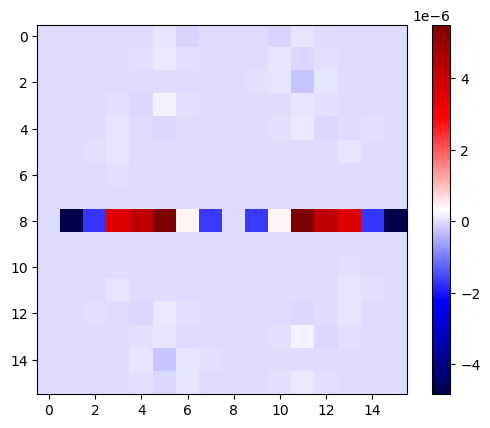

In [13]:
plt.imshow((linear2_3_q_k_pred[:,:,-1]+linear2_1_q_k_pred[:,:,-1] - rhs_q21_k_t[:,:,-1]).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

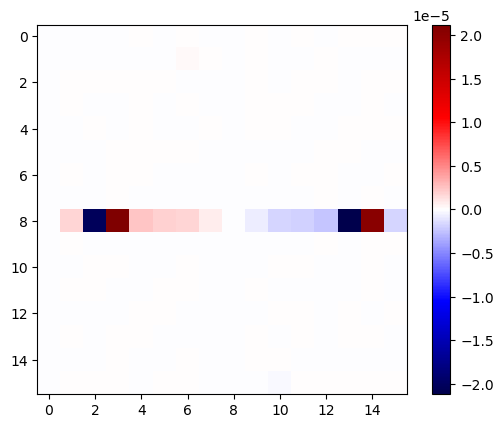

In [12]:
plt.imshow((linear2_3_q_k_pred[:,:,-1]+linear2_1_q_k_pred[:,:,-1] - rhs_q21_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

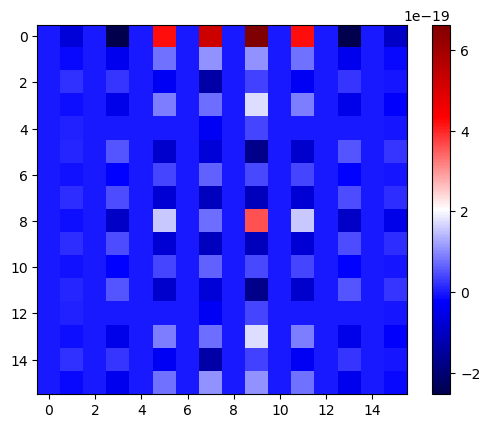

In [16]:
plt.imshow((linear2_3_q_k_pred[:,:,-1] - rhs_q23_k_t[:,:,-1]).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

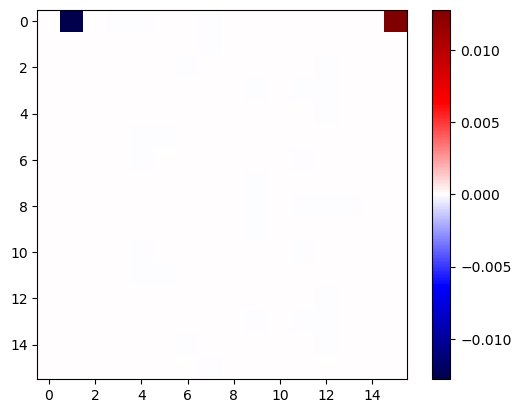

In [15]:
plt.imshow((linear2_3_q_k_pred[:,:,-1] - rhs_q23_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

the error is from the rhs_q21

**finally find the bug in linear part: there should not be $U*dX*hk$ term in q2 RHS**

In [18]:
# increments
inc1_k_t = np.zeros((K, K, N), dtype=complex)
inc2_k_t = np.zeros((K, K, N), dtype=complex)
inc1_k_t[:, :, 1:] = psi1_k_t[:, :, 1:N] - psi1_k_t[:, :, :N-1]
inc2_k_t[:, :, 1:] = psi2_k_t[:, :, 1:N] - psi2_k_t[:, :, :N-1]

# reshape flattened variables to two modes matrices
psi1_k_pred = psi1_k_pred.reshape((K,K,-1), order='F')
psi2_k_pred = psi2_k_pred.reshape((K,K,-1), order='F')
jacob1_k_pred = jacob1_k_pred.reshape((K,K,-1), order='F')
jacob2_k_pred = jacob2_k_pred.reshape((K,K,-1), order='F')
linear1_k_pred = linear1_k_pred.reshape((K,K,-1), order='F')
linear2_k_pred = linear2_k_pred.reshape((K,K,-1), order='F')
psi2_k_pred.shape

# Jacobian terms in dq/dt should be transformed to d\psi/dt according to eq.(35)
jacob1_k_t_ = jacob_k_t[:,:,:N,0]
jacob2_k_t_ = jacob_k_t[:,:,:N,1]

# define Ck for each wave number
Ck = 1 / (K_squared * (K_squared + kd**2))
Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

# reshape for proper broadcasting
jacob1_k_t_ = np.transpose(jacob1_k_t_, axes=(2,0,1))
jacob2_k_t_ = np.transpose(jacob2_k_t_, axes=(2,0,1))

jacob1_k_t = -Ck * ((K_squared + kd**2/2) * jacob1_k_t_ + kd**2/2 * jacob2_k_t_)
jacob2_k_t = -Ck * (kd**2/2 * jacob1_k_t_ + (K_squared + kd**2/2) * jacob2_k_t_)

# reshape back
jacob1_k_t = np.transpose(jacob1_k_t, axes=(1,2,0))
jacob2_k_t = np.transpose(jacob2_k_t, axes=(1,2,0))

# linear inc
linear1_k_t = inc1_k_t - jacob1_k_t
linear2_k_t = inc2_k_t - jacob2_k_t

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_16397/3994344812.py:21: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


In [56]:
# reshape for proper broadcasting
rhs1_k_t = rhs_q_k_t[:,:,:,0]
rhs2_k_t = rhs_q_k_t[:,:,:,1]
rhs1_k_t = np.transpose(rhs1_k_t, axes=(2,0,1))
rhs2_k_t = np.transpose(rhs2_k_t, axes=(2,0,1))

rhs1_k_t = -Ck * ((K_squared + kd**2/2) * rhs1_k_t + kd**2/2 * rhs2_k_t)
rhs2_k_t = -Ck * (kd**2/2 * rhs1_k_t + (K_squared + kd**2/2) * rhs2_k_t)

# reshape back
rhs1_k_t = np.transpose(rhs1_k_t, axes=(1,2,0))
rhs2_k_t = np.transpose(rhs2_k_t, axes=(1,2,0))


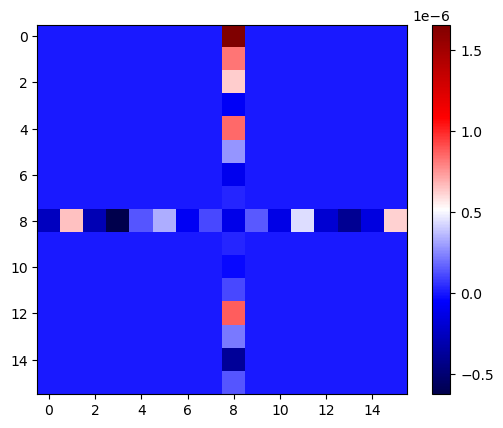

In [69]:
plt.imshow((rhs1_k_t[:,:,-1] - inc1_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

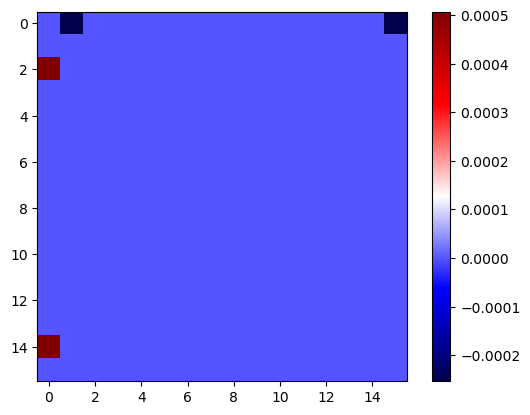

In [105]:

plt.imshow((nu*50*h_hat/(101)).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

In [90]:
# reshape for proper broadcasting
linear1_k_t_ = np.transpose(linear1_k_t, axes=(2,0,1))
linear2_k_t_ = np.transpose(linear2_k_t, axes=(2,0,1))

linear1_q_k_t = -(K_squared + kd**2/2) * linear1_k_t_ + kd**2/2 * linear2_k_t_
linear2_q_k_t = kd**2/2 * linear1_k_t_ - (K_squared + kd**2/2) * linear2_k_t_

# reshape back
linear1_q_k_t = np.transpose(linear1_q_k_t, axes=(1,2,0))
linear2_q_k_t = np.transpose(linear2_q_k_t, axes=(1,2,0))

In [95]:
# reshape for proper broadcasting
linear1_k_pred_ = np.transpose(linear1_k_pred, axes=(2,0,1))
linear2_k_pred_ = np.transpose(linear2_k_pred, axes=(2,0,1))

linear1_q_k_pred = -(K_squared + kd**2/2) * linear1_k_pred_ + kd**2/2 * linear2_k_pred_
linear2_q_k_pred = kd**2/2 * linear1_k_pred_ - (K_squared + kd**2/2) * linear2_k_pred_

# reshape back
linear1_q_k_pred = np.transpose(linear1_q_k_pred, axes=(1,2,0))
linear2_q_k_pred = np.transpose(linear2_q_k_pred, axes=(1,2,0))

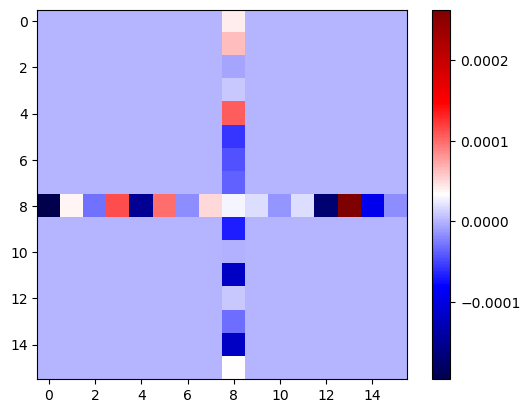

In [97]:
plt.imshow((linear1_q_k_pred[:,:,-1] - linear1_q_k_t[:,:,-1]).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

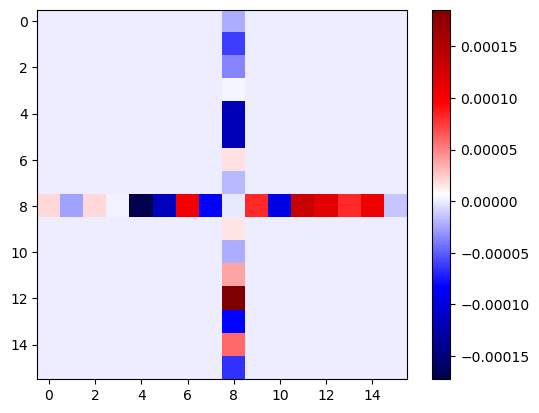

In [96]:
plt.imshow((linear1_q_k_pred[:,:,-1] - linear1_q_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

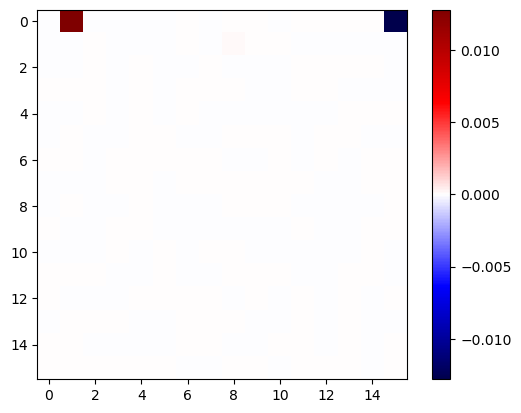

In [98]:
plt.imshow((linear2_q_k_pred[:,:,-1] - linear2_q_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

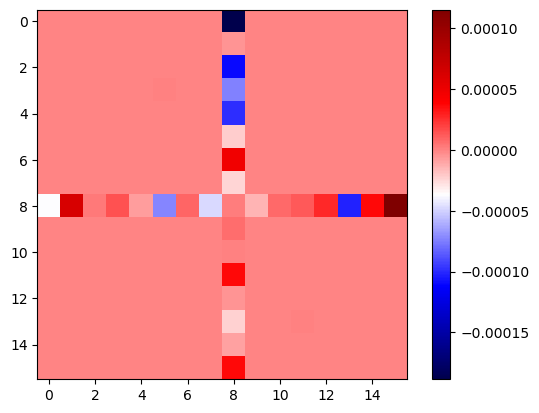

In [99]:
plt.imshow((linear2_q_k_pred[:,:,-1] - linear2_q_k_t[:,:,-1]).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

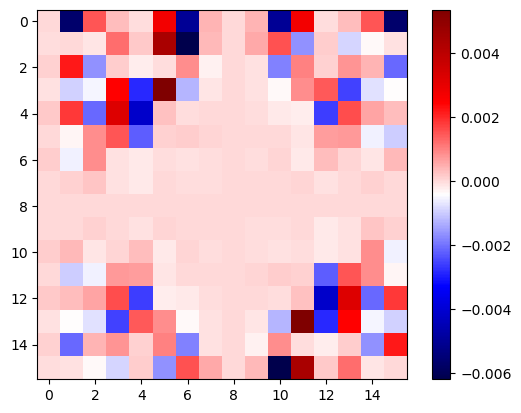

In [101]:
plt.imshow((linear2_q_k_pred[:,:,-1]).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

In [92]:
rhs1_q_k_t = rhs_q_k_t[:,:,:,0]
rhs2_q_k_t = rhs_q_k_t[:,:,:,1]

In [94]:
jacob1_q_k_t_ = jacob_k_t[:,:,:N,0]
jacob2_q_k_t_ = jacob_k_t[:,:,:N,1]

In [ ]:
linear

acceptable because the difference in dX, dY (Nyquist frequency)

after correct the bug in matlab code: RHS lower layer $U*dX*hk$

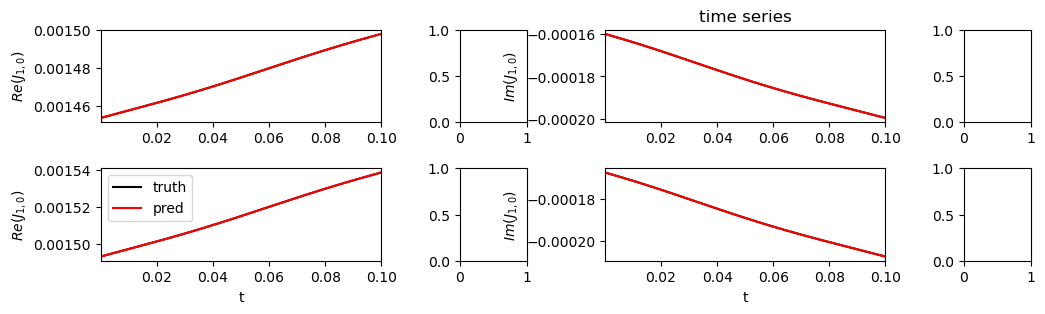

In [19]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 1; iky = 0 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

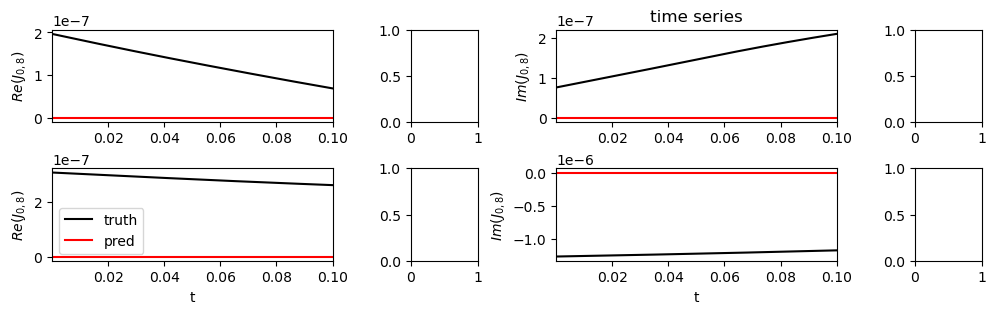

In [20]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 0; iky = 8 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

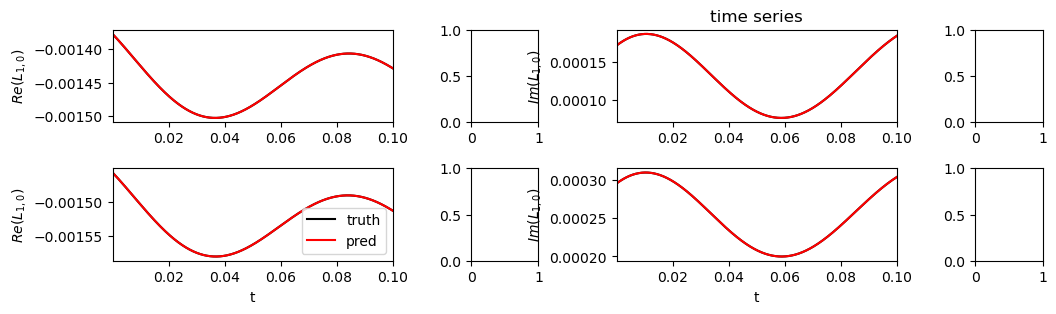

In [21]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 1; iky = 0 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, linear1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, linear1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(L_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, linear2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, linear2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(L_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, linear1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, linear1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(L_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, linear2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, linear2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(L_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

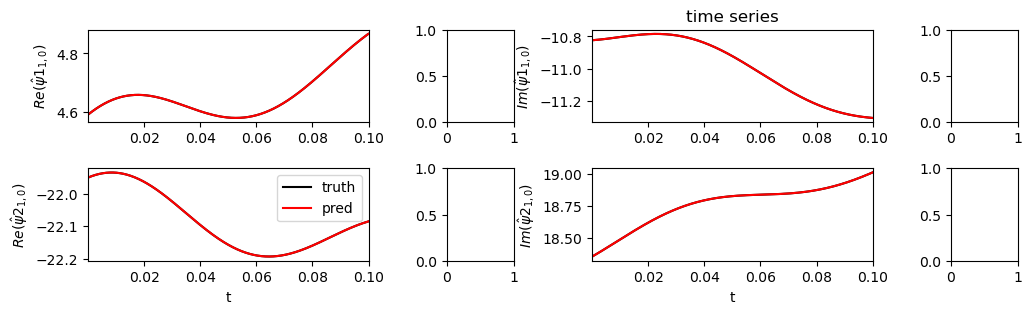

In [22]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 1; iky = 0 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

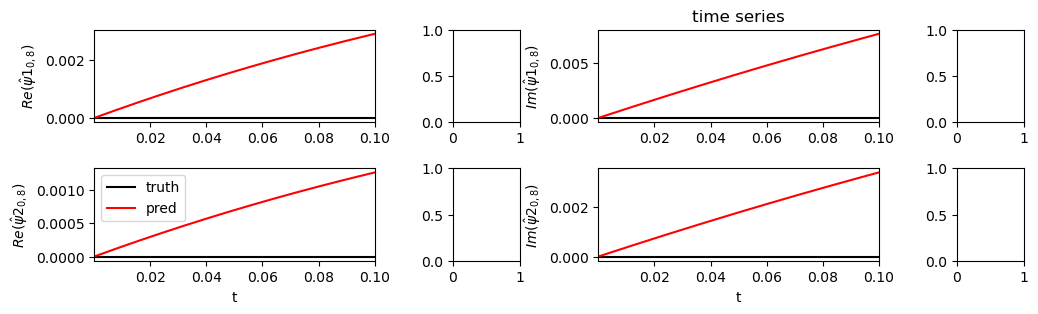

In [23]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 0; iky = 8 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

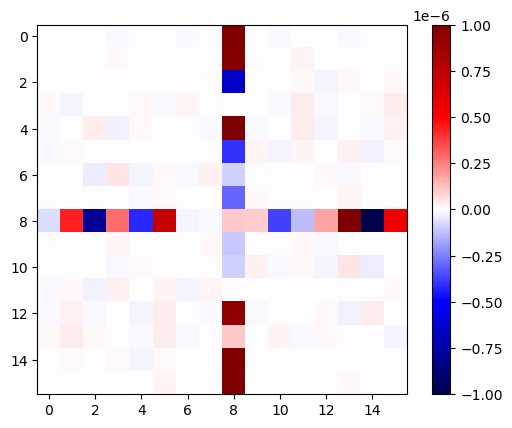

In [24]:
plt.imshow((jacob1_k_pred[:,:,-1] - jacob1_k_t[:,:,-1]).real, cmap='seismic', vmin=-1e-6, vmax=1e-6)
plt.colorbar()

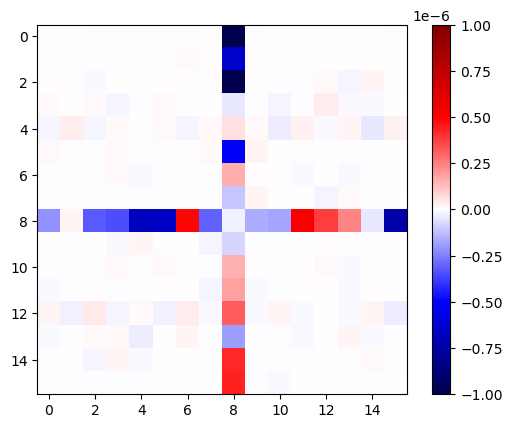

In [25]:
plt.imshow((jacob1_k_pred[:,:,-1] - jacob1_k_t[:,:,-1]).imag, cmap='seismic', vmin=-1e-6, vmax=1e-6)
plt.colorbar()

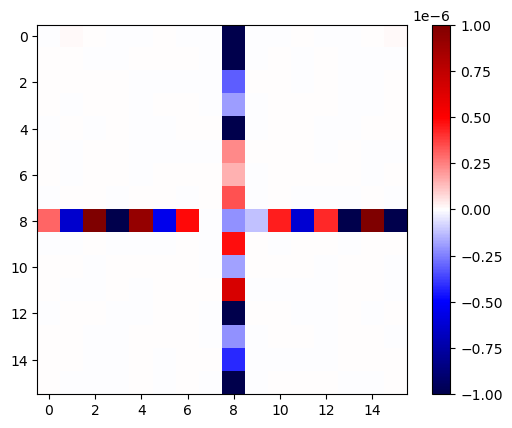

In [26]:
plt.imshow((linear1_k_pred[:,:,-1] - linear1_k_t[:,:,-1]).real, cmap='seismic', vmin=-1e-6, vmax=1e-6)
plt.colorbar()

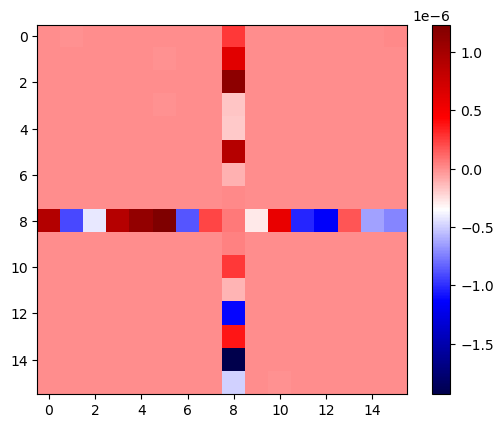

In [27]:
plt.imshow((linear1_k_pred[:,:,-1] - linear1_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

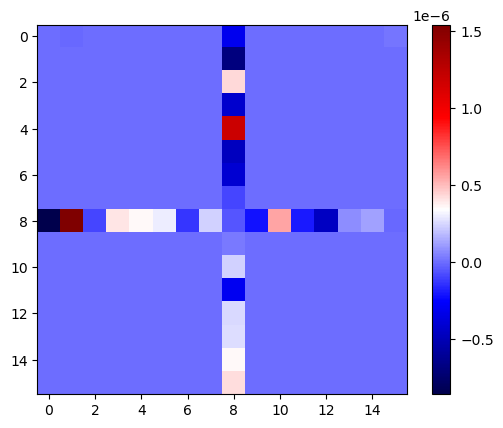

In [28]:
plt.imshow((linear2_k_pred[:,:,-1] - linear2_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

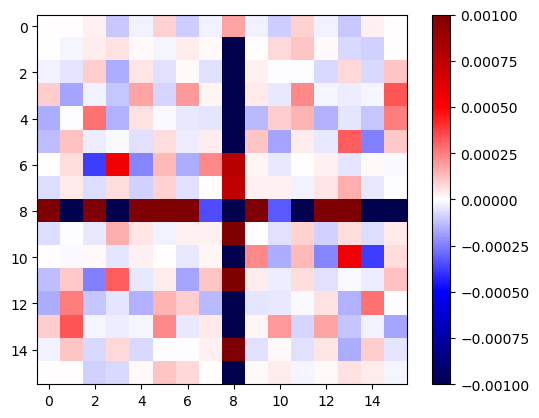

In [29]:
plt.imshow((psi1_k_pred[:,:,-1] - psi1_k_t[:,:,-1]).real, cmap='seismic', vmin=-1e-3, vmax=1e-3)
plt.colorbar()

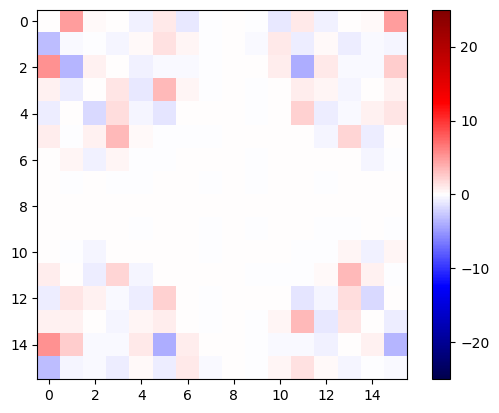

In [30]:
plt.imshow(psi1_k_t[:,:,-1].real, cmap='seismic', vmin=-25, vmax=25)
plt.colorbar()

The difference between python and Matlab: the last even mode: -8 vs 8 (error can be neglected)

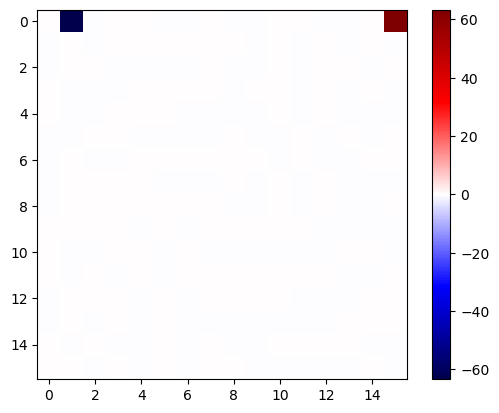

In [91]:
plt.imshow((psi1_k_pred[:,:,-1] - psi1_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

only the (1,0) and (-1,0) modes

after enforce the Nyquist frequency of dX to be zero

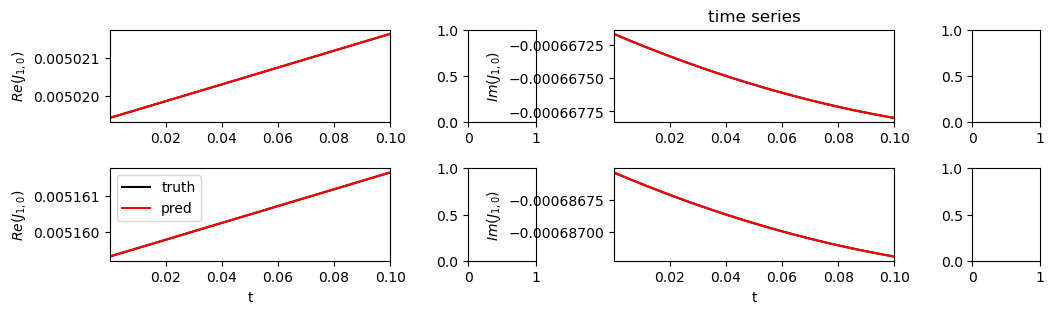

In [138]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 1; iky = 0 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

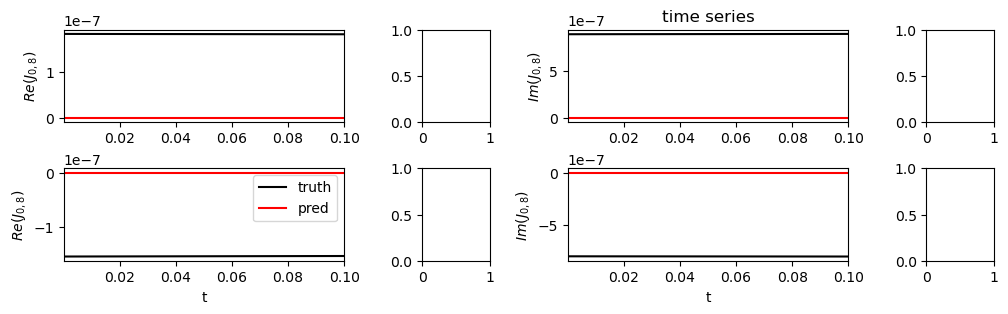

In [139]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 0; iky = 8 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

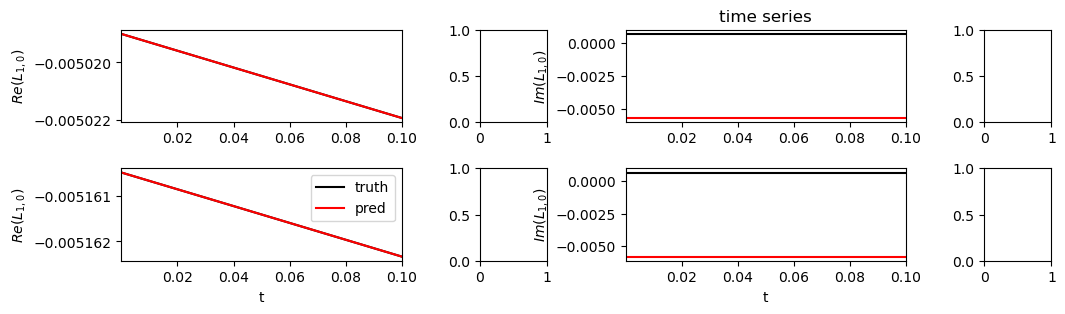

In [140]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 1; iky = 0 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, linear1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, linear1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(L_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, linear2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, linear2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(L_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, linear1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, linear1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(L_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, linear2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, linear2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(L_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

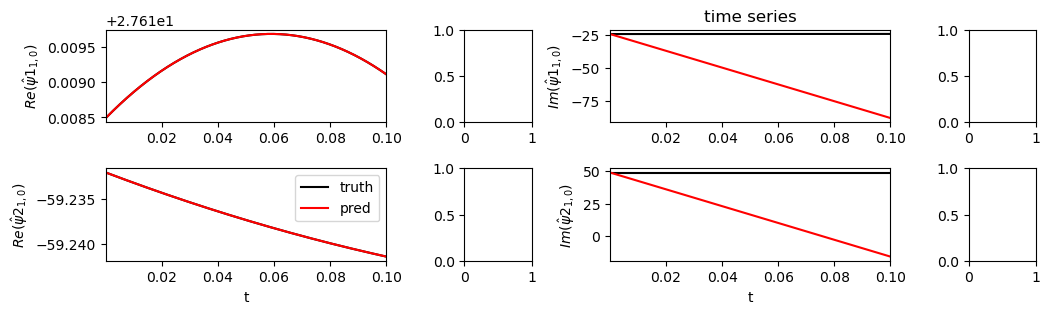

In [141]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 1; iky = 0 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

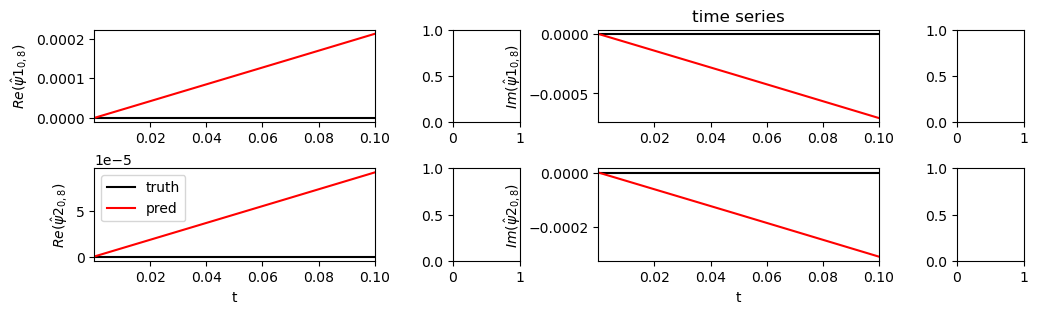

In [142]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 0; iky = 8 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

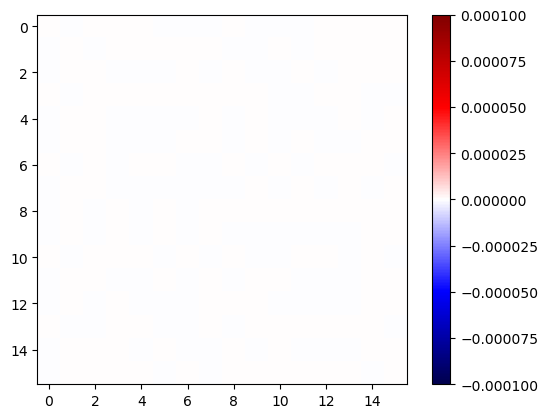

In [143]:
plt.imshow((jacob1_k_pred[:,:,-1] - jacob1_k_t[:,:,-1]).real, cmap='seismic', vmin=-1e-4, vmax=1e-4)
plt.colorbar()

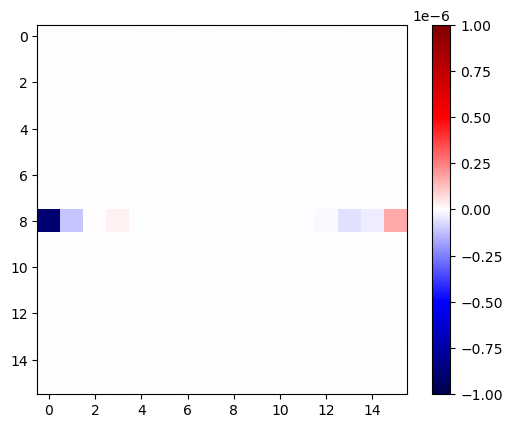

In [144]:
plt.imshow((jacob1_k_pred[:,:,-1] - jacob1_k_t[:,:,-1]).imag, cmap='seismic', vmin=-1e-6, vmax=1e-6)
plt.colorbar()

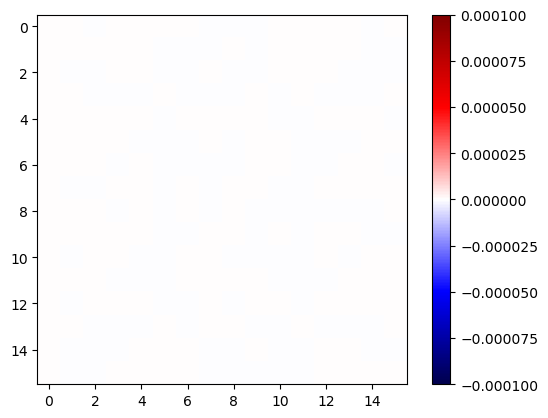

In [145]:
plt.imshow((linear1_k_pred[:,:,-1] - linear1_k_t[:,:,-1]).real, cmap='seismic', vmin=-1e-4, vmax=1e-4)
plt.colorbar()

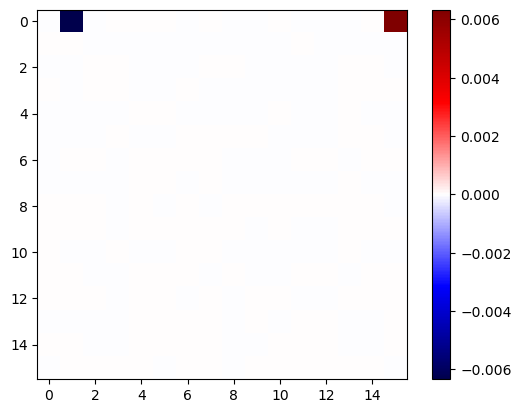

In [146]:
plt.imshow((linear1_k_pred[:,:,-1] - linear1_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

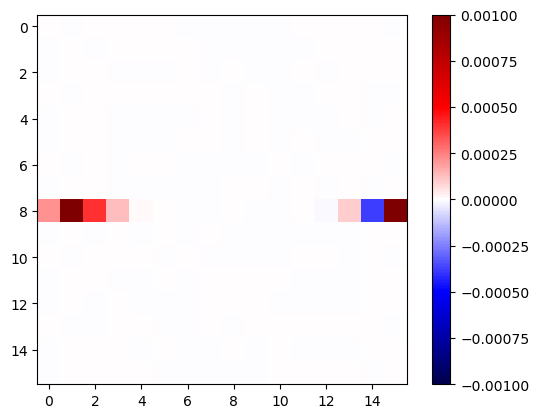

In [147]:
plt.imshow((psi1_k_pred[:,:,-1] - psi1_k_t[:,:,-1]).real, cmap='seismic', vmin=-1e-3, vmax=1e-3)
plt.colorbar()

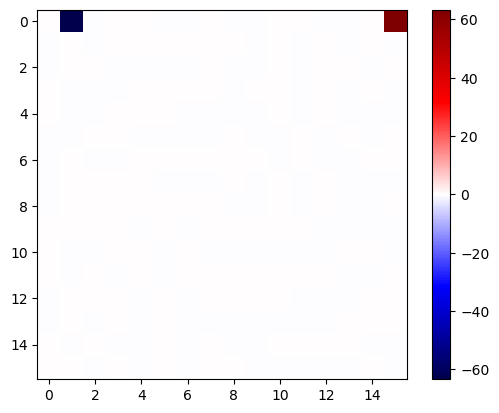

In [148]:
plt.imshow((psi1_k_pred[:,:,-1] - psi1_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

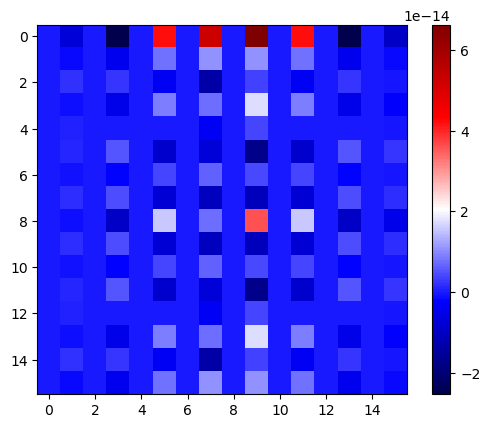

In [76]:
plt.imshow((1j * KX * h_hat).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

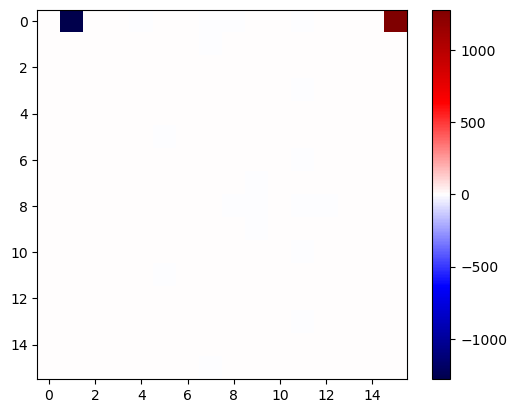

In [77]:
plt.imshow((1j * KX * h_hat).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

In [81]:
KX_ = np.array(KX)
KX_[:,8] = 8

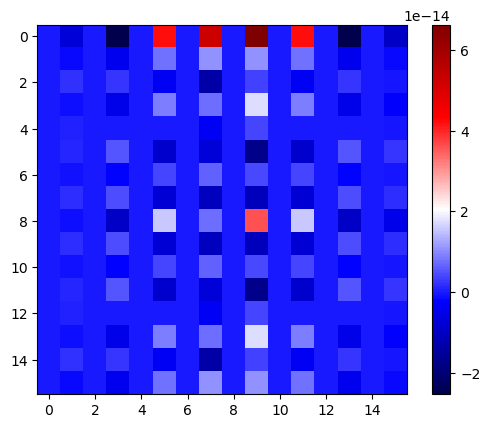

In [82]:
plt.imshow((1j * KX_ * h_hat).real, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

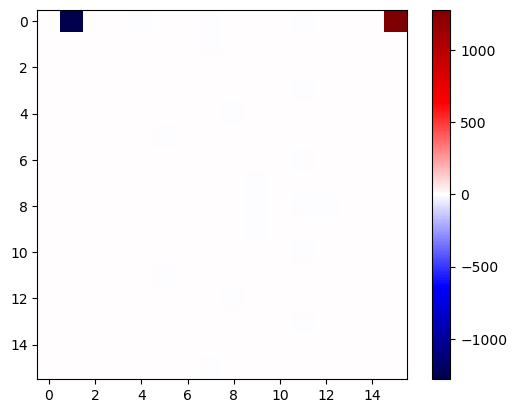

In [83]:
plt.imshow((1j * KX_ * h_hat).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

test h_hat

In [23]:
h_hat[0,1]

(-1280+7.435207313522959e-15j)

In [24]:
h_hat[0,-1]

(-1280-9.464233404386145e-15j)

In [162]:
# check model prediction - Euler, prior is truth
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    h_hat[0,1] = 0
    h_hat[0,-1] = 0
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # enforce conjugate symmetry
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0
#     psi1_hat[:, K//2, :] = 0
#     psi2_hat[:, K//2, :] = 0

    # Precompute constants
    K_squared_kd2 = K_squared + kd**2 / 2
    K_squared2 = K_squared**2
    K_squared4 = K_squared**4
    invCk = K_squared * (K_squared + kd**2)
    dX = 1j * KX
    dX[:, K//2] = 0 # enforce conjugate symmetry

    # linear part for A0, a0, A1 and a1
    linear_A0 = dX * ((K_squared_kd2 * beta - K_squared2 * U) * psi1_hat - kd**2/2 * U * h_hat) - nu * K_squared4 * (invCk * psi1_hat - kd**2/2 * h_hat)
    linear_a0 = dX * ((kd**2/2 * beta - kd**2 * K_squared * U) * psi1_hat - K_squared_kd2 * U * h_hat) + nu * K_squared4 * K_squared_kd2 * h_hat
    linear_A1_diag = dX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = dX * (K_squared_kd2 * beta + K_squared2 * U) - K_squared_kd2 * kappa * K_squared - nu * K_squared4 * invCk
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    for ik_, (k, ik) in enumerate(k_index_map.items()):
        kx, ky = k
        ikx, iky = ik
        k_sq = kx**2 + ky**2
        for im_, (m, im) in enumerate(k_index_map.items()):
            mx, my = m
            imx, imy = im
            m_sq = mx**2 + my**2
            psi1_m = psi1_hat[:, imy, imx]
            n = (kx-mx, ky-my)
            if n in k_index_map:
                inx, iny = k_index_map[n]
                psi1_n = psi1_hat[:, iny, inx]
                h_n = h_hat[iny, inx]
                det_mn = np.linalg.det(np.array([m, n]))
                nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_sq + kd**2/2) * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2/2 * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_A1[:, ik_, im_] += det_mn * kd**2/2 * (k_sq * psi1_n - h_n)
                nonlinear_sum_a1[:, ik_, im_] -= det_mn * (k_sq * kd**2/2 * psi1_n + (k_sq + kd**2/2) * h_n) 
        
    nonlinear_sum_A0 = nonlinear_sum_A0 / K**2
    nonlinear_sum_a0 = nonlinear_sum_a0 / K**2
    nonlinear_sum_A1 = nonlinear_sum_A1 / K**2
    nonlinear_sum_a1 = nonlinear_sum_a1 / K**2
    
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    nonlinear_sum_A1[:, K//2::K, :] = 0
    nonlinear_sum_A1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_a1[:, K//2::K, :] = 0
    nonlinear_sum_a1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_A0[:, :, K//2] = 0
    nonlinear_sum_a0[:, :, K//2] = 0
    nonlinear_sum_A0[:, K//2, :] = 0
    nonlinear_sum_a0[:, K//2, :] = 0
    A1[:, K//2::K, :] = 0
    A1[:, K//2*K:(K//2+1)*K, :] = 0
    a1[:, K//2::K, :] = 0
    a1[:, K//2*K:(K//2+1)*K, :] = 0
    
    # normalization 
    Ck = 1 / invCk
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1, nonlinear_sum_A0*Ck, nonlinear_sum_a0*Ck, nonlinear_sum_A1*Ck_, nonlinear_sum_a1*Ck_

N = 10000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# initialized
psi1_k_pred = np.zeros((K*K, N), dtype=complex)
psi2_k_pred = np.zeros((K*K, N), dtype=complex)
jacob1_k_pred = np.zeros((K*K, N), dtype=complex)
jacob2_k_pred = np.zeros((K*K, N), dtype=complex)
linear1_k_pred = np.zeros((K*K, N), dtype=complex)
linear2_k_pred = np.zeros((K*K, N), dtype=complex)
psi1_k_pred[:, 0] = psi1_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
psi2_k_pred[:, 0] = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
N_chunk = 2000 

for i in range(1, N):
    i_chunk = (i-1) % N_chunk
    if i_chunk == 0:
        A0_t, a0_t, A1_t, a1_t, nonlinear_A0_t, nonlinear_a0_t, nonlinear_A1_t, nonlinear_a1_t = get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_k_t[:,:,i-1:i-1+N_chunk], psi2_k_t[:,:,i-1:i-1+N_chunk], h_hat)
    
    A0 = A0_t[i_chunk, :]
    a0 = a0_t[i_chunk, :]
    A1 = A1_t[i_chunk, :, :]
    a1 = a1_t[i_chunk, :, :]

    nonlinear_A0 = nonlinear_A0_t[i_chunk, :, :]
    nonlinear_a0 = nonlinear_a0_t[i_chunk, :, :]
    nonlinear_A1 = nonlinear_A1_t[i_chunk, :, :]
    nonlinear_a1 = nonlinear_a1_t[i_chunk, :, :]

    jacob1_k_pred[:, i] = (nonlinear_A0.flatten(order='F') + nonlinear_A1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt 
    jacob2_k_pred[:, i] = (nonlinear_a0.flatten(order='F') + nonlinear_a1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt 
    linear1_k_pred[:, i] = (A0 + A1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt - jacob1_k_pred[:, i]
    linear2_k_pred[:, i] = (a0 + a1 @ psi2_k_t[:, :, i-1].flatten(order='F')) * dt - jacob2_k_pred[:, i]
    
    # forecast
    psi1_k_pred[:, i] = psi1_k_pred[:, i-1] + jacob1_k_pred[:, i] + linear1_k_pred[:, i]
    psi2_k_pred[:, i] = psi2_k_pred[:, i-1] + jacob2_k_pred[:, i] + linear2_k_pred[:, i] 

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_6848/3167092381.py:91: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [163]:
# increments
inc1_k_t = np.zeros((K, K, N), dtype=complex)
inc2_k_t = np.zeros((K, K, N), dtype=complex)
inc1_k_t[:, :, 1:] = psi1_k_t[:, :, 1:N] - psi1_k_t[:, :, :N-1]
inc2_k_t[:, :, 1:] = psi2_k_t[:, :, 1:N] - psi2_k_t[:, :, :N-1]

# reshape flattened variables to two modes matrices
psi1_k_pred = psi1_k_pred.reshape((K,K,-1), order='F')
psi2_k_pred = psi2_k_pred.reshape((K,K,-1), order='F')
jacob1_k_pred = jacob1_k_pred.reshape((K,K,-1), order='F')
jacob2_k_pred = jacob2_k_pred.reshape((K,K,-1), order='F')
linear1_k_pred = linear1_k_pred.reshape((K,K,-1), order='F')
linear2_k_pred = linear2_k_pred.reshape((K,K,-1), order='F')
psi2_k_pred.shape

# Jacobian terms in dq/dt should be transformed to d\psi/dt according to eq.(35)
jacob1_k_t_ = jacob_k_t[:,:,:N,0]
jacob2_k_t_ = jacob_k_t[:,:,:N,1]

# define Ck for each wave number
Ck = 1 / (K_squared * (K_squared + kd**2))
Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode

# reshape for proper broadcasting
jacob1_k_t_ = np.transpose(jacob1_k_t_, axes=(2,0,1))
jacob2_k_t_ = np.transpose(jacob2_k_t_, axes=(2,0,1))

jacob1_k_t = -Ck * ((K_squared + kd**2/2) * jacob1_k_t_ + kd**2/2 * jacob2_k_t_)
jacob2_k_t = -Ck * (kd**2/2 * jacob1_k_t_ + (K_squared + kd**2/2) * jacob2_k_t_)

# reshape back
jacob1_k_t = np.transpose(jacob1_k_t, axes=(1,2,0))
jacob2_k_t = np.transpose(jacob2_k_t, axes=(1,2,0))

# linear inc
linear1_k_t = inc1_k_t - jacob1_k_t
linear2_k_t = inc2_k_t - jacob2_k_t

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_6848/3994344812.py:21: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / (K_squared * (K_squared + kd**2))


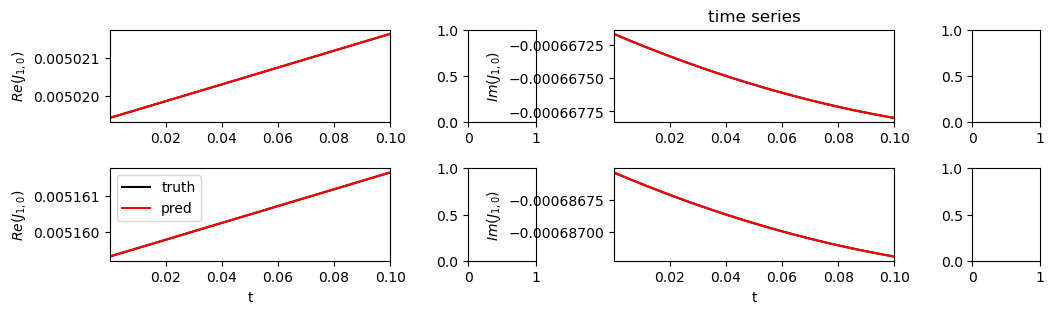

In [164]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 1; iky = 0 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

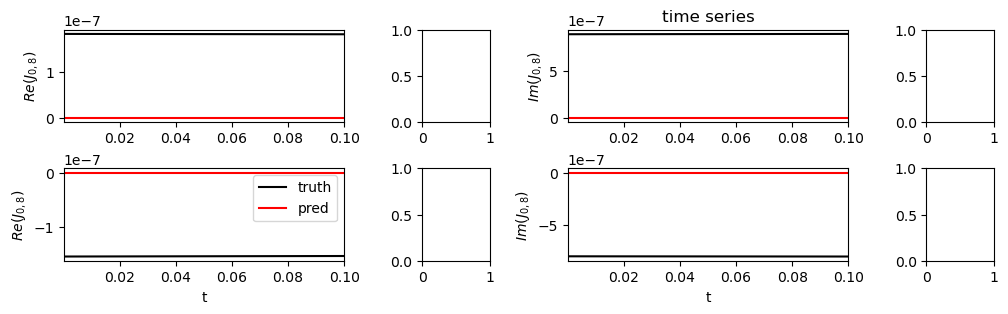

In [165]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 0; iky = 8 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, jacob1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, jacob1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, jacob2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, jacob2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(J_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

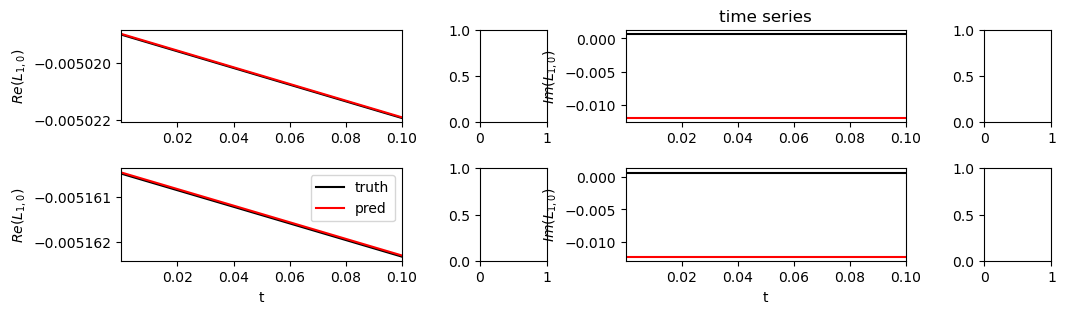

In [166]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 1; iky = 0 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, linear1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, linear1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(L_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, linear2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, linear2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(L_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, linear1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, linear1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(L_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, linear2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, linear2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(L_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

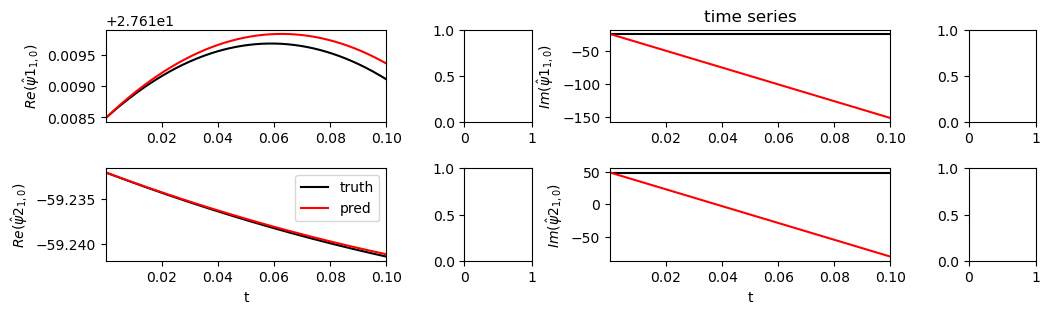

In [167]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 1; iky = 0 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

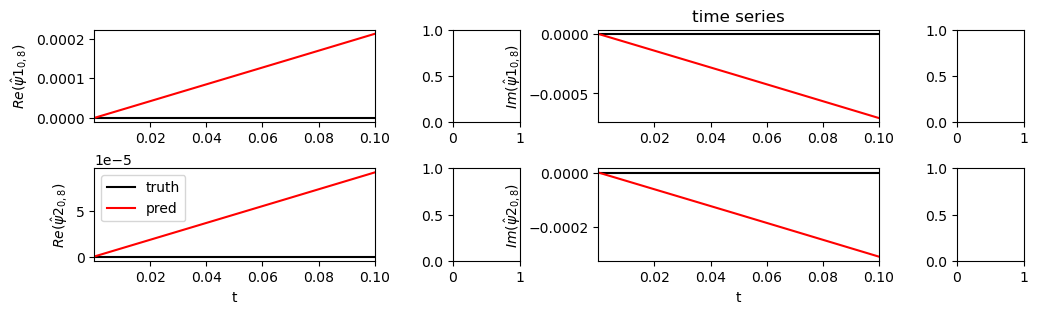

In [168]:
# Plot
sel0 = 1; sel1 = N # plot time range
ikx = 0; iky = 8 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax1.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].real, 'r', label='pred')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax3.plot(xticks, p, 'k')
# ax3.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].real
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].real
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax11.plot(xaxis, psi1_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, psi2_k_pred[iky,ikx,sel0:sel1:interv].imag, 'r', label='pred')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# # plot pdf
# samples = psi1_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax33.plot(xticks, p, 'k')
# ax33.set_title('PDF')

# samples = psi2_k_t[iky, ikx, :N].imag
# kde = gaussian_kde(samples)
# xticks = np.linspace(samples.min(), samples.max(), 100)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'k', label='truth')
# samples = psi2_k_pred[iky, ikx, :].imag
# kde = gaussian_kde(samples)
# p = kde.evaluate(xticks)
# ax44.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LagDA_K16_CG_tr.png',dpi=100)
plt.show()

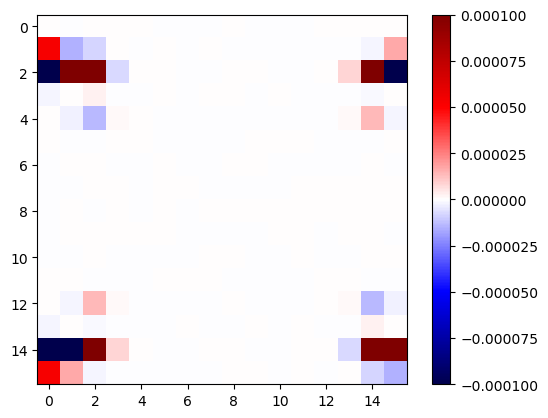

In [169]:
plt.imshow((jacob1_k_pred[:,:,-1] - jacob1_k_t[:,:,-1]).real, cmap='seismic', vmin=-1e-4, vmax=1e-4)
plt.colorbar()

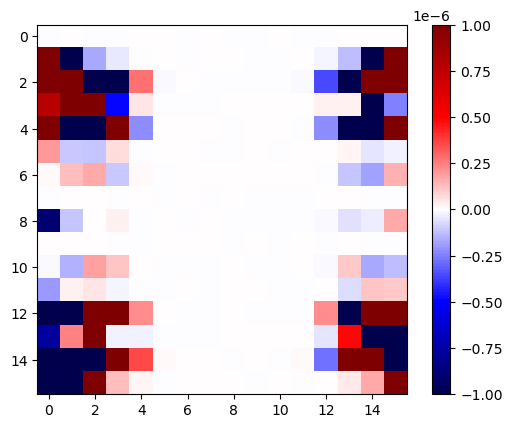

In [170]:
plt.imshow((jacob1_k_pred[:,:,-1] - jacob1_k_t[:,:,-1]).imag, cmap='seismic', vmin=-1e-6, vmax=1e-6)
plt.colorbar()

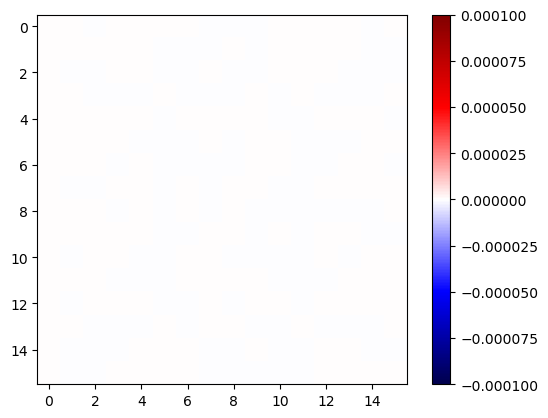

In [171]:
plt.imshow((linear1_k_pred[:,:,-1] - linear1_k_t[:,:,-1]).real, cmap='seismic', vmin=-1e-4, vmax=1e-4)
plt.colorbar()

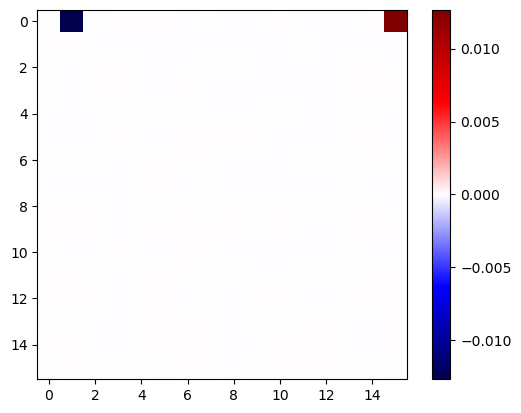

In [172]:
plt.imshow((linear1_k_pred[:,:,-1] - linear1_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()

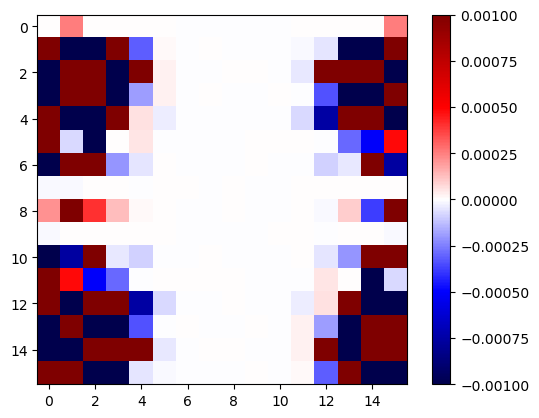

In [173]:
plt.imshow((psi1_k_pred[:,:,-1] - psi1_k_t[:,:,-1]).real, cmap='seismic', vmin=-1e-3, vmax=1e-3)
plt.colorbar()

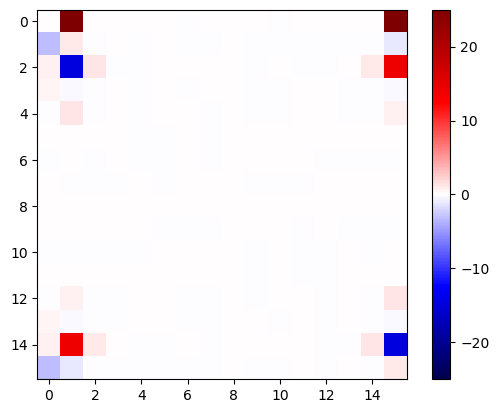

In [174]:
plt.imshow(psi1_k_t[:,:,-1].real, cmap='seismic', vmin=-25, vmax=25)
plt.colorbar()

The difference between python and Matlab: the last even mode: -8 vs 8 (error can be neglected)

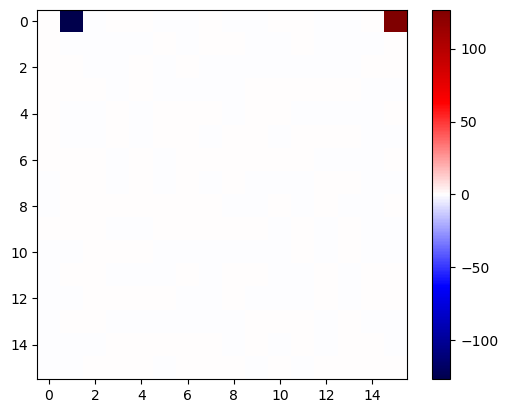

In [175]:
plt.imshow((psi1_k_pred[:,:,-1] - psi1_k_t[:,:,-1]).imag, cmap='seismic')#, vmin=-1, vmax=1)
plt.colorbar()